In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime

In [2]:
train = pd.read_csv("../input/g-research-crypto-forecasting/train.csv",
                              dtype = {'Asset_ID' : 'int8', 'Count' : 'float16', 'Open' : 'float32', 
                                       'High' : 'float32', 'Low' : 'float32', 'Close' : 'float32', 
                                       'Volume' : 'float16', 'VWAP' : 'float16', 'Target' : 'float16'})

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int8   
 2   Count      float16
 3   Open       float32
 4   High       float32
 5   Low        float32
 6   Close      float32
 7   Volume     float16
 8   VWAP       float16
 9   Target     float16
dtypes: float16(4), float32(4), int64(1), int8(1)
memory usage: 762.8 MB


### Reducing the memory usage of the dataframe

In [3]:
asset_details = pd.read_csv("../input/g-research-crypto-forecasting/asset_details.csv")

asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


### Sorting the asset_details dataframe and adding Asset tickers

In [4]:
asset_details.sort_values(by='Asset_ID', inplace=True)
asset_details.set_index('Asset_ID', inplace=True)
asset_details['Asset_Ticker'] = ['BNB', #Binance Coin
                                 'BTC', #Bitcoin
                                 'BCH', #Bitcoin Cash
                                 'ADA', #Cardano
                                 'DOGE', #Dogecoin
                                 'EOS', #EOS
                                 'ETH', #Etherium
                                 'ETC', #Etherium Classic
                                 'MIOTA', #IOTA
                                 'LTC', #Litecoin
                                 'MKR', #Maker
                                 'XMR', #Monero
                                 'XLM', #Stellar
                                 'TRX' #TRON
                                ]
asset_details

,Weight,Asset_Name,Asset_Ticker
Asset_ID,,,
0,4.304065,Binance Coin,BNB
1,6.779922,Bitcoin,BTC
2,2.397895,Bitcoin Cash,BCH
3,4.406719,Cardano,ADA
4,3.555348,Dogecoin,DOGE
5,1.386294,EOS.IO,EOS
6,5.894403,Ethereum,ETH
7,2.079442,Ethereum Classic,ETC
8,1.098612,IOTA,MIOTA


## Note: For the purpose of this project we will only focus on four key assets: Bitcoin, Etherium, Litecoin, Dogecoin. For these assets we will impute missing data, and plot the time series.

### Creating training dataframe for each asset

In [5]:
train_copy = train.copy().set_index("timestamp")


##Bitcoin
train_BTC = train_copy[train_copy['Asset_ID']==1]

##Dogecoin
train_DOGE = train_copy[train_copy['Asset_ID']==4]

##Etherium (Ether)
train_ETH = train_copy[train_copy['Asset_ID']==6]

##Litecoin
train_LTC = train_copy[train_copy['Asset_ID']==9]

Asset_list = [train_BTC, train_DOGE, train_ETH, train_LTC]

### Creating function to explore timeline, missing timestamps, and to impute missing timestamps for each asset

In [6]:
##Explore function with asset dataframe as input
def explore(Asset):
    
    #Asset ID
    ID = int(Asset.Asset_ID.values[0])
    
    #tickername
    name = asset_details[asset_details.index==ID]['Asset_Name'].values[0]
    
    #timeline
    first = Asset.index[0].astype('datetime64[s]')
    last = Asset.index[-1].astype('datetime64[s]')
    
    print(f"The timeline for {name} is from \n{first} to {last}\n")
    
    #Each consecutive timestamp should be in the increment of 60. A gap more than that reveals the missing asset data
    gaps = (Asset.index[1:] - Asset.index[:-1]).value_counts().head(10)
    
    return print(f"The gap values for {name} are\n", gaps,"\n")

### Exploring the missing target values and imputing them

In [7]:
##Imputing missing timestamps
train_BTC = train_BTC.reindex(range(train_BTC.index[0], train_BTC.index[-1]+60, 60), method='pad')
train_ETH = train_ETH.reindex(range(train_ETH.index[0], train_ETH.index[-1]+60, 60), method='pad')
train_LTC = train_LTC.reindex(range(train_LTC.index[0], train_LTC.index[-1]+60, 60), method='pad')
train_DOGE = train_DOGE.reindex(range(train_DOGE.index[0], train_DOGE.index[-1]+60, 60), method='pad')


##Imputing the missing values with 0
train_BTC.Target.fillna(0,inplace=True)
train_ETH.Target.fillna(0,inplace=True)
train_LTC.Target.fillna(0,inplace=True)
train_DOGE.Target.fillna(0,inplace=True)

In [8]:
train_BTC.shape, train_ETH.shape, train_LTC.shape, train_DOGE.shape

((1956960, 9), (1956960, 9), (1956960, 9), (1285047, 9))

## Visualizing the complete time series

In [9]:
import matplotlib.pyplot as plt


#Visualize function to plot complete daily time series of closing price of each asset
def visualize(Asset, color):
    
    f = plt.figure(figsize=(15,4))
    
    #Asset ID
    ID = int(Asset.Asset_ID.values[0])
    
    #label
    label = asset_details[asset_details.index==ID]['Asset_Name'].values[0]
    
    
    #timeline
    timeline = pd.to_datetime(Asset.index, unit = 's').date
    
    #plot with legends and axis labels
    plt.plot(timeline, Asset['Close'], label=label, color=color)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(f'{label} price in USD')
    
    plt.show()
    
    return None

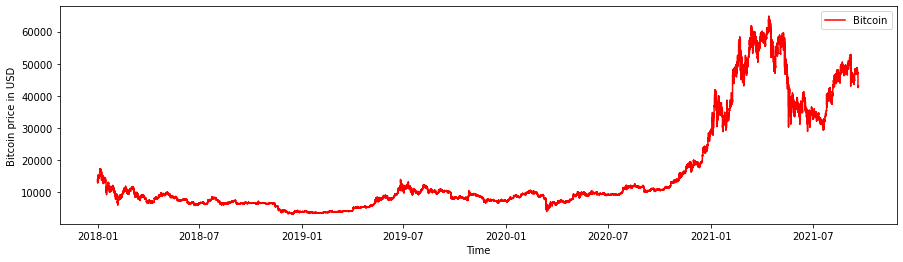

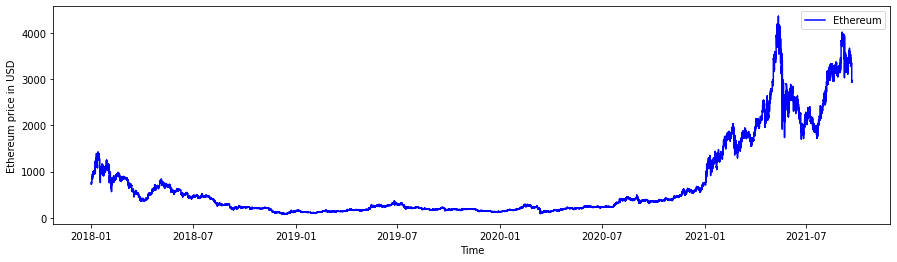

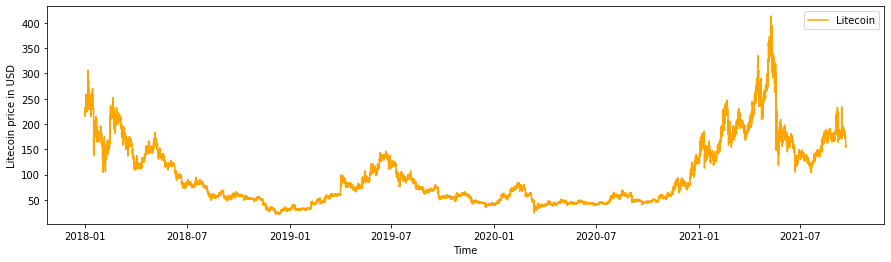

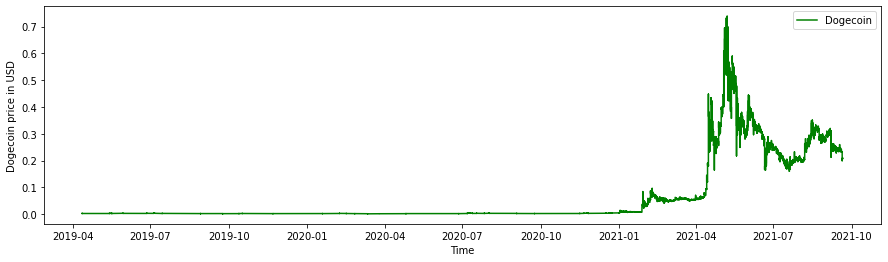

(None, None, None, None)

In [10]:
visualize(train_BTC, 'red'), visualize(train_ETH, 'blue'), visualize(train_LTC, 'orange'), visualize(train_DOGE, 'green')

#### Note: Due to storage constraint and also vast difference in the history of assets we will choose the recent and more dynamic data. For exploratory purposes we will choose the 1st May 2021 to 31st May 2021 time window.

In [11]:
import time
import matplotlib as mpl
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller


totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, '%d/%m/%Y').timetuple()))
start = '01/05/2021'
end = '31/05/2021'

recent_BTC = train_BTC.loc[totimestamp(start): totimestamp(end)]
recent_ETH = train_ETH.loc[totimestamp(start): totimestamp(end)]
recent_LTC = train_LTC.loc[totimestamp(start): totimestamp(end)]
recent_DOGE = train_DOGE.loc[totimestamp(start): totimestamp(end)]

In [12]:
recent_BTC.shape, recent_ETH.shape, recent_LTC.shape, recent_DOGE.shape

((43201, 9), (43201, 9), (43201, 9), (43201, 9))

## Performing Statistical Tests

### Autocorrelation

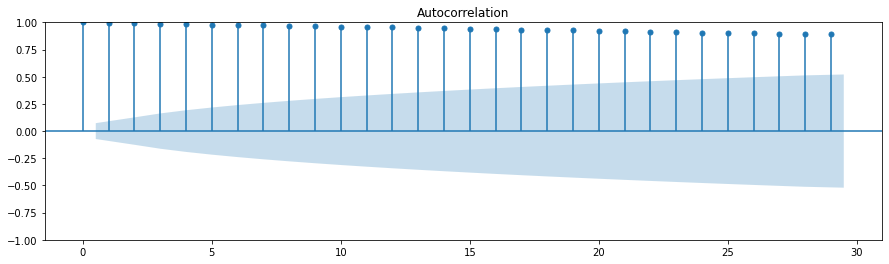

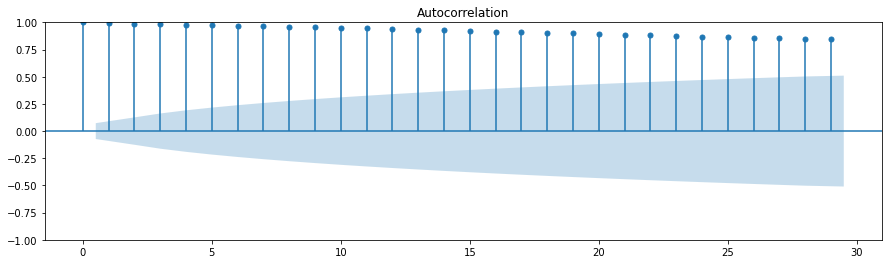

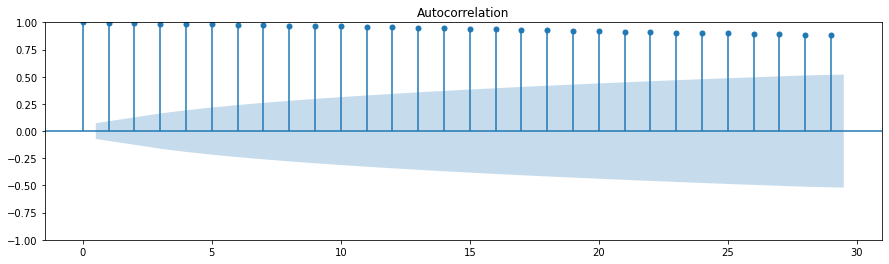

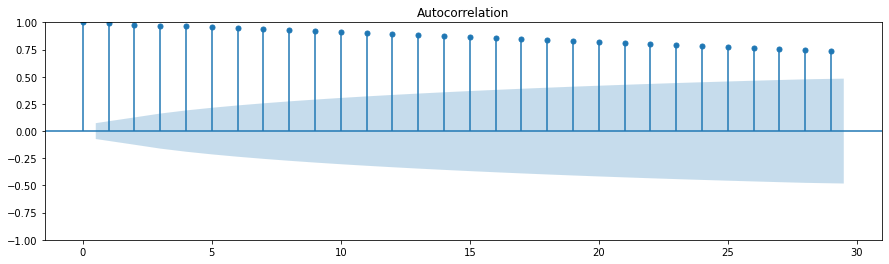

In [13]:
##Autocorrelation on hourly frequency of the closing prices data
with mpl.rc_context():
    mpl.rc("figure", figsize=(15,4))
    plot_acf(recent_BTC.iloc[::60,5])
    plot_acf(recent_ETH.iloc[::60,5])
    plot_acf(recent_LTC.iloc[::60,5])
    plot_acf(recent_DOGE.iloc[::60,5])
    plt.show()

#### The autocorrelation in hourly closing prices is almost close to one upto 30 lags. Increasing the period length from 1 hour to 1 day might reveal different results 

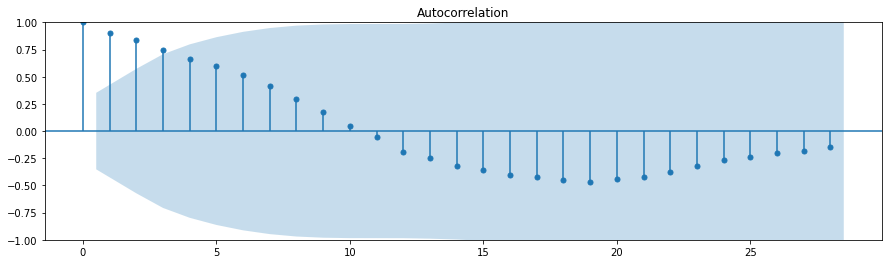

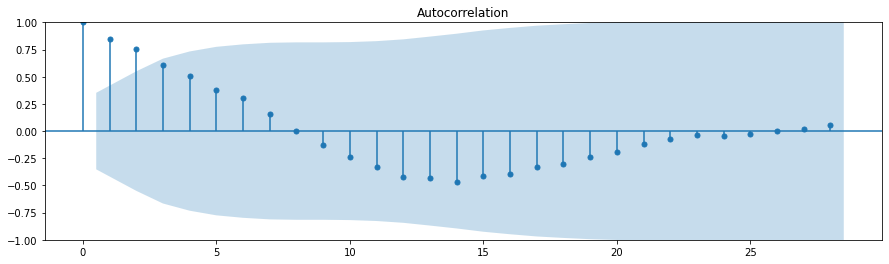

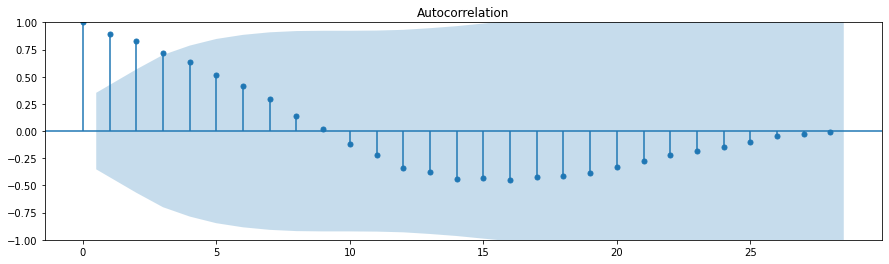

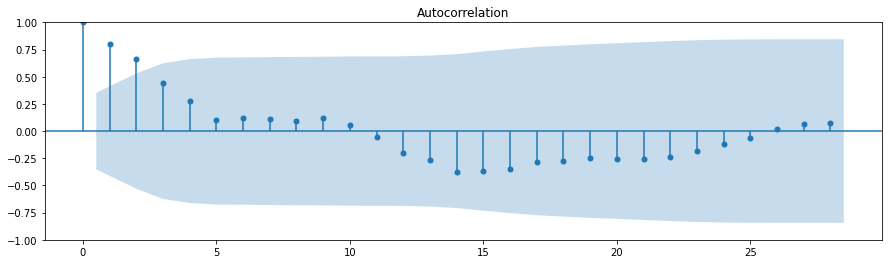

In [14]:
##Autocorrelation on daily frequency of the closing prices data for 28 lags

with mpl.rc_context():
    mpl.rc("figure", figsize=(15,4))
    plot_acf(recent_BTC.iloc[::1440,5], lags=28)
    plot_acf(recent_ETH.iloc[::1440,5], lags=28)
    plot_acf(recent_LTC.iloc[::1440,5], lags=28)
    plot_acf(recent_DOGE.iloc[::1440,5], lags=28)
    plt.show()

#### For Bitcoin, the autocorrelation monotonously shrinks to zero at 10th lag. And it continues to decreas and reaches minimum around 18th lag and again increases and reaches near zero value around 28th lag.

#### For Etherium, the autocorrelation decreases and changes its sign at 8th lag. It decreases further and reaches minimum at 14th lag and increases and stays to near zero values from 23rd lag afterwards.

#### For Etherium, the autocorrelation decreases and changes its sign at 9th lag. It decreases further and reaches minimum at 16th lag and increases to zero around 27th lag.

#### For Dogecoin, the autocorrelation curve is not smooth and sine-wave like. It decreases swiftly til 5th lag and then fluctuates till 10th lag until it changes its sign from positive to negative. It reaches minimum at 14th lag and fluctuates again until it reaches zero at 26th lag. 

### Augmented Dicky Fullers Test

#### To check stationarity of the time series we will perform the augmented Dicky Fullers Test. This test is against the null hypothesis that time series is non stationary. The p-value of the test represents that probability that the null hypothesis cannot be rejected.

In [15]:
result = adfuller(recent_BTC.Close)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'n-lags: {result[2]}')
print('Critial Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -0.7356618963777571
p-value: 0.8372948340180572
n-lags: 50
Critial Values:
1%: -3.430501557104466
5%: -2.861606984893264
10%: -2.5668056538840904


In [16]:
result = adfuller(recent_ETH.Close)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'n-lags: {result[2]}')
print('Critial Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -1.0138821044739168
p-value: 0.7481675090015619
n-lags: 50
Critial Values:
1%: -3.430501557104466
5%: -2.861606984893264
10%: -2.5668056538840904


In [17]:
result = adfuller(recent_LTC.Close)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'n-lags: {result[2]}')
print('Critial Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -0.5414072433899466
p-value: 0.8836797555499027
n-lags: 51
Critial Values:
1%: -3.430501560617088
5%: -2.8616069864457256
10%: -2.566805654710422


In [18]:
result = adfuller(recent_DOGE.Close)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'n-lags: {result[2]}')
print('Critial Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -1.529041417969079
p-value: 0.519099192305999
n-lags: 55
Critial Values:
1%: -3.4305015746692042
5%: -2.861606992656292
10%: -2.5668056580161327


#### The p-values for all the assets is significantly greater than 0.05 which indicates that none of these timeseries are stationary in the given time window. Hence we cannot use traditional AR, ARMA, ARIMA models on this time series. Rather we would multioutput Regression for this timeseries

## Modeling

### Feature selection

#### We will use following features:
#### 1. Upper Shadow
#### 2. Lower Shadow
#### 3. 5 mins log return
#### 4. absolute 5 mins log return

In [19]:
## Function to calculate log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

## Functions to calculate upper and lower shadow
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close, asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close, asset.Open) - asset.Low

X_BTC = pd.concat([log_return(train_BTC.VWAP, periods=5), log_return(train_BTC.VWAP, periods=5).abs(), 
                   upper_shadow(train_BTC), lower_shadow(train_BTC)], axis=1)
y_BTC = train_BTC.Target

X_ETH = pd.concat([log_return(train_ETH.VWAP, periods=5), log_return(train_ETH.VWAP, periods=5).abs(), 
                   upper_shadow(train_ETH), lower_shadow(train_ETH)], axis=1)
y_ETH = train_ETH.Target

X_LTC = pd.concat([log_return(train_LTC.VWAP, periods=5), log_return(train_LTC.VWAP, periods=5).abs(), 
                   upper_shadow(train_LTC), lower_shadow(train_LTC)], axis=1)
y_LTC = train_LTC.Target

X_DOGE = pd.concat([log_return(train_DOGE.VWAP, periods=5), log_return(train_DOGE.VWAP, periods=5).abs(), 
                   upper_shadow(train_DOGE), lower_shadow(train_DOGE)], axis=1)
y_DOGE = train_DOGE.Target

In [20]:
## selecting training and testing windows

train_window = [totimestamp("01/05/2021"), totimestamp("31/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]


X_BTC_train = X_BTC.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_BTC_train = y_BTC.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()

X_BTC_test = X_BTC.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_BTC_test = y_BTC.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

X_ETH_train = X_ETH.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_ETH_train = y_ETH.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()

X_ETH_test = X_ETH.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_ETH_test = y_ETH.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

X_LTC_train = X_LTC.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_LTC_train = y_LTC.loc[train_window[0]:train_window[1]].fillna(0).to_numpy() 

X_LTC_test = X_LTC.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_LTC_test = y_LTC.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

X_DOGE_train = X_DOGE.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_DOGE_train = y_DOGE.loc[train_window[0]:train_window[1]].fillna(0).to_numpy() 

X_DOGE_test = X_DOGE.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_DOGE_test = y_DOGE.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_BTC_train_scaled = scaler.fit_transform(X_BTC_train)
X_BTC_test_scaled = scaler.transform(X_BTC_test)

X_ETH_train_scaled = scaler.fit_transform(X_ETH_train)
X_ETH_test_scaled = scaler.transform(X_ETH_test)

X_LTC_train_scaled = scaler.fit_transform(X_LTC_train)
X_LTC_test_scaled = scaler.transform(X_LTC_test)

X_DOGE_train_scaled = scaler.fit_transform(X_DOGE_train)
X_DOGE_test_scaled = scaler.transform(X_DOGE_test)

In [22]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

##Concatenating inputs along column or axis level
X_all_train = np.concatenate((X_BTC_train_scaled, X_ETH_train_scaled, X_LTC_train_scaled, X_DOGE_train_scaled), axis=1)
X_all_test = np.concatenate((X_BTC_test_scaled, X_ETH_test_scaled, X_LTC_test_scaled, X_DOGE_test_scaled), axis=1)

##Stacking the outputs columnwise (1 column for each asset)
y_all_train = np.column_stack((y_BTC_train, y_ETH_train, y_LTC_train, y_DOGE_train))
y_all_test = np.column_stack((y_BTC_test, y_ETH_test, y_LTC_test, y_DOGE_test))

# define the direct multioutput model and fit it
mlr = MultiOutputRegressor(LinearRegression())
mlr.fit(X_all_train,y_all_train)
y_pred_lr_all = mlr.predict(X_all_test)

In [23]:
print("Correlation coefficient for multiple output regression:\nBitcoin :", f"{np.corrcoef(y_pred_lr_all[:,0], y_all_test[:,0])[0,1]:.2f}",
     "\nEtherium :", f"{np.corrcoef(y_pred_lr_all[:,1], y_all_test[:,1])[0,1]:.2f}",
     "\nLitecoin :", f"{np.corrcoef(y_pred_lr_all[:,2], y_all_test[:,2])[0,1]:.2f}",
     "\nDogecoin :", f"{np.corrcoef(y_pred_lr_all[:,3], y_all_test[:,3])[0,1]:.2f}")

Correlation coefficient for multiple output regression:
Bitcoin : 0.01 
Etherium : 0.04 
Litecoin : 0.03 
Dogecoin : 0.01


#### Due to the dynamic and volatile nature of crypto prices the correlation between test Target values and predicted Target values is relatively low but it is nonetheless positive.